### Method to estimate the bias probability density and the force component related to the probability density. Typically contain set of 10 to 20 x-y position data.

#### First, define constants, base functions and load positions.

In [2]:
import numpy as np
import os
import time
import glob
import matplotlib.pyplot as plt
from numba import jit, njit
from matplotlib import ticker

In [3]:
#Define grid 
min_grid=np.array((-np.pi, -np.pi))
max_grid=np.array((np.pi, np.pi))
nbins=np.array((200, 200))
gridy = np.linspace(min_grid[1], max_grid[1], nbins[1])
gridx = np.linspace(min_grid[0], max_grid[0], nbins[0])
grid_space = np.array(((max_grid[0] - min_grid[0]) / (nbins[0]-1), (max_grid[1] - min_grid[1]) / (nbins[1]-1)))
X, Y = np.meshgrid(gridx, gridy)
#Define constants
bw = 0.1
bw2 = bw**2
stride = 10
const = (1 / (bw * np.sqrt(2 * np.pi) * stride))
kT = 1
x0, y0 = 0,0

In [4]:
def load_HILLS_2D(hills_name="../data/HILLS"):
	"""Load 2-dimensional hills data (includes time, position_x, position_y, hills_parameters ).
	
	Args:
		hills_name (str, optional): Name of hills file. Defaults to "HILLS".
	Returns:
		np.array: Array with hills data
	"""
	for file in glob.glob(hills_name):
		hills = np.loadtxt(file)
		hills = np.concatenate(([hills[0]], hills[:-1]))
		hills[0][5] = 0
	return hills

def load_position_2D(position_name="../data/position"):
	"""Load 2-dimensional position/trajectory data.

	Args:
		position_name (str, optional): Name of position file. Defaults to "position".

	Returns:
		list: 2 * np.array with position data of each dimension ([position_x, position_y])
	"""
	for file1 in glob.glob(position_name):
		colvar = np.loadtxt(file1)
		position_x = colvar[:-1, 1]
		position_y = colvar[:-1, 2]
	return [position_x, position_y]

def find_periodic_point(x_coord, y_coord, min_grid, max_grid, periodic):
	"""Finds periodic copies of input coordinates. 
	
	Args:
		x_coord (float): CV1-coordinate
		y_coord (float): CV2-coordinate
		min_grid (list): list of CV1-minimum value of grid and CV2-minimum value of grid
		max_grid (list): list of CV1-maximum value of grid and CV2-maximum value of grid
		periodic (binary): information if system is periodic. value of 0 corresponds to non-periodic system; function will only return input coordinates. Value of 1 corresponds to periodic system; function will return input coordinates with periodic copies.
	Returns:
		list: list of [x-coord, y-coord] pairs
	"""

	coord_list = []
	coord_list.append([x_coord, y_coord])
	
	if periodic == 1:
		# Use periodic extension for defining PBC
		periodic_extension = periodic * 1 / 2
		grid_ext = (1 / 2) * periodic_extension * (max_grid - min_grid)

		# There are potentially 4 points, 1 original and 3 periodic copies, or less.

		copy_record = [0, 0, 0, 0]
		# check for x-copy
		if x_coord < min_grid[0] + grid_ext[0]:
			coord_list.append([x_coord + 2 * np.pi, y_coord])
			copy_record[0] = 1
		elif x_coord > max_grid[0] - grid_ext[0]:
			coord_list.append([x_coord - 2 * np.pi, y_coord])
			copy_record[1] = 1
		# check for y-copy
		if y_coord < min_grid[1] + grid_ext[1]:
			coord_list.append([x_coord, y_coord + 2 * np.pi])
			copy_record[2] = 1
		elif y_coord > max_grid[1] - grid_ext[1]:
			coord_list.append([x_coord, y_coord - 2 * np.pi])
			copy_record[3] = 1
		# check for xy-copy
		if sum(copy_record) == 2:
			if copy_record[0] == 1 and copy_record[2] == 1:
				coord_list.append([x_coord + 2 * np.pi, y_coord + 2 * np.pi])
			elif copy_record[1] == 1 and copy_record[2] == 1:
				coord_list.append([x_coord - 2 * np.pi, y_coord + 2 * np.pi])
			elif copy_record[0] == 1 and copy_record[3] == 1:
				coord_list.append([x_coord + 2 * np.pi, y_coord - 2 * np.pi])
			elif copy_record[1] == 1 and copy_record[3] == 1:
				coord_list.append([x_coord - 2 * np.pi, y_coord - 2 * np.pi])        

	return coord_list

In [5]:
HILLS = load_HILLS_2D("../data/HILLS40")
[p_x,p_y] = load_position_2D("../data/position40")

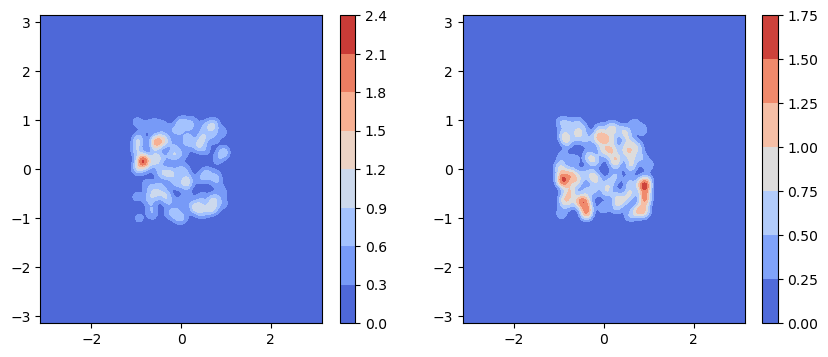

In [20]:
import random

pb_t = np.zeros_like(X)
bw = 0.1
bw2 = bw**2
stride = 10
const = (1 / (bw * np.sqrt(2 * np.pi) * stride))

pb_t2 = np.zeros_like(X)
bw_2 = 0.1
bw2_2 = bw**2
stride2 = 10
const2 = (1 / (bw_2 * np.sqrt(2 * np.pi) * stride2))

for j in range(100):
    
    a , b = (random.randint(0,200) / 100 - 1), (random.randint(0,200) / 100 - 1)
    
    kernel = const * np.exp( - (1 / (2 * bw2)) * ((X - a ) ** 2 + (Y - b ) ** 2))
    pb_t = pb_t + kernel
    
    kernel2 = const2 * np.exp( - (1 / (2 * bw2_2)) * ((X - a ) ** 2 + (Y - b ) ** 2))
    pb_t2 = pb_t2 + kernel2

plt.figure(1,figsize=(10,4))
plt.subplot(1,2,1) 
plt.contourf(X,Y,pb_t, cmap="coolwarm")#, levels = np.linspace(-80,80,11))
plt.colorbar()
plt.subplot(1,2,2) 
plt.contourf(X,Y,pb_t2, cmap="coolwarm")#, levels = np.linspace(-80,80,11))
plt.colorbar()

### (0) Naive method

In [6]:
#Number of evaluations
nhills = 200
n_eval = int(nhills / (stride/10))
[pos_x, pos_y] = [p_x[:stride*n_eval],p_y[:stride*n_eval]]

In [7]:
def gaus_normal(data_x, data_y):
	
	pb_t = np.zeros_like(X)
	Fpbt_x = np.zeros_like(X)
	Fpbt_y = np.zeros_like(X)
	
	for j in range(len(data_x)):
		kernel = const * np.exp( - (1 / (2 * bw2)) * ((X - data_x[j]) ** 2 + (Y - data_y[j]) ** 2))
		pb_t = pb_t + kernel
		Fpbt_x = Fpbt_x + kernel * kT * (X - data_x[j]) / bw2
		Fpbt_y = Fpbt_y + kernel * kT * (Y - data_y[j]) / bw2
		
	return [pb_t, Fpbt_x, Fpbt_y]

In [8]:
#-->Run Gaus normal
results = np.zeros((3,nbins[0],nbins[1]))
start = time.time()
for i in range(n_eval): results += gaus_normal(pos_x[i*stride: (i+1)*stride],pos_y[i*stride: (i+1)*stride]) 
[P, FX, FY] = results

t_normal = time.time()-start	
print("time for >>gaus_normal<< is:", t_normal)

time for >>gaus_normal<< is: 1.5076110363006592


Text(0.5, 1.0, 'FX normal')

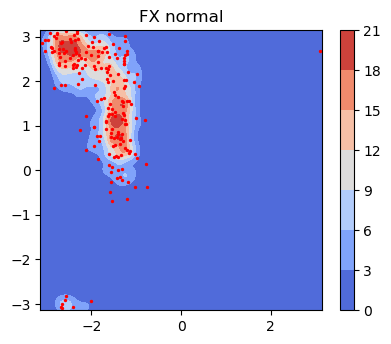

In [9]:
plt.figure(1, figsize=(10,8))
plt.subplot(2,2,1)
plt.contourf(X,Y,P, cmap="coolwarm")#, levels = np.linspace(-80,80,11))
plt.colorbar()
plt.scatter(HILLS[:n_eval,1], HILLS[:n_eval,2], c="r", s=2)
plt.title("FX normal")

### (1) Numpy mothod (optimise the use of numpy)

In [14]:
def gaus_numpy(data_x, data_y):
	
	pb_t = np.zeros_like(X)
	Fpbt_x = np.zeros_like(X)
	Fpbt_y = np.zeros_like(X)
	
	for j in range(len(data_x)):
		kernel_x = np.exp( - np.square(gridx - data_x[j]) / (2 * bw2))
		kernel_y = np.exp( - np.square(gridy - data_y[j]) / (2 * bw2))
		kernel = const * np.outer(kernel_y, kernel_x)
  	 
		pb_t = pb_t + kernel
		# kernel = kernel 
		Fpbt_x = Fpbt_x + kT / bw2 * np.multiply(kernel , (X - data_x[j]) )
		Fpbt_y = Fpbt_y + kT / bw2 * np.multiply(kernel , (Y - data_y[j]) )
	
	return [pb_t, Fpbt_x, Fpbt_y]

def gaus_numpy2(data_x, data_y):
	
	pb_t = np.zeros_like(X)
	Fpbt_x = np.zeros_like(X)
	Fpbt_y = np.zeros_like(X)
 	
	for j in range(len(data_x)):
		kernel_x = np.exp( - np.square(gridx - data_x[j]) / (2 * bw2)) * const #add constant here for less computations
		kernel_y = np.exp( - np.square(gridy - data_y[j]) / (2 * bw2))
		kernel = np.outer(kernel_y, kernel_x) 

		kernel_x = kernel_x * kT / bw2 #add constant here for less computations

		pb_t = pb_t + kernel
		Fpbt_x = Fpbt_x + np.outer(kernel_y, np.multiply(kernel_x, (gridx - data_x[j])) )
		Fpbt_y = Fpbt_y + np.outer(np.multiply(kernel_y, (gridy - data_y[j])) , kernel_x )
  
	return [pb_t, Fpbt_x, Fpbt_y]

def gaus_numpy3(data_x, data_y):
	
	pb_t = np.zeros_like(X)
	Fpbt_x = np.zeros_like(X)
	Fpbt_y = np.zeros_like(X)
 	
	for j in range(len(data_x)):
		kernel_x = np.exp( - np.square(gridx - data_x[j]) / (2 * bw2)) 
		kernel_y = np.exp( - np.square(gridy - data_y[j]) / (2 * bw2))
		kernel = np.outer(kernel_y, kernel_x) * const # alternative position to add the constant

		pb_t = pb_t + kernel
		Fpbt_x = Fpbt_x + np.outer(kernel_y, np.multiply(kernel_x, (gridx - data_x[j])) ) * const * kT / bw2 # alternative position to add the constant
		Fpbt_y = Fpbt_y + np.outer(np.multiply(kernel_y, (gridy - data_y[j])) , kernel_x ) * const * kT / bw2 # alternative position to add the constant
  
	return [pb_t, Fpbt_x, Fpbt_y]

In [16]:
#-->Run Gaus Numpy2
results = np.zeros((3,nbins[0],nbins[1]))
start = time.time()
for i in range(n_eval): results += gaus_numpy2(pos_x[i*stride: (i+1)*stride],pos_y[i*stride: (i+1)*stride]) 
[Ps, FXs, FYs] = results
t_numpy2 = time.time()-start

print("time for >>gaus_numpy2<< is:", t_numpy2)
print("time saving:", round(100*(t_normal - t_numpy2)/t_normal, 2), "%")
print("differecen in pb_t:", sum(sum(abs(P - Ps))) / 200**2, "\ndifferecen in FX:", sum(sum(abs(FX - FXs))) / 200**2, "\ndifferecen in FY:", sum(sum(abs(FY - FYs))) / 200**2)

#-->Run Gaus Numpy2
results = np.zeros((3,nbins[0],nbins[1]))
start = time.time()
for i in range(n_eval): results += gaus_numpy3(pos_x[i*stride: (i+1)*stride],pos_y[i*stride: (i+1)*stride]) 
[Ps, FXs, FYs] = results
t_numpy3 = time.time()-start

print("time for >>gaus_numpy3<< is:", t_numpy3)
print("time saving:", round(100*(t_normal - t_numpy3)/t_normal, 2), "%")
print("differecen in pb_t:", sum(sum(abs(P - Ps))) / 200**2, "\ndifferecen in FX:", sum(sum(abs(FX - FXs))) / 200**2, "\ndifferecen in FY:", sum(sum(abs(FY - FYs))) / 200**2)


time for >>gaus_numpy2<< is: 0.46303701400756836
time saving: 69.29 %
differecen in pb_t: 8.995700619499324e-17 
differecen in FX: 5.117251809357462e-16 
differecen in FY: 4.301644674152304e-16
time for >>gaus_numpy3<< is: 0.8302035331726074
time saving: 44.93 %
differecen in pb_t: 8.57910651098466e-17 
differecen in FX: 5.000724689212364e-16 
differecen in FY: 4.317612557838543e-16


### (2) No-Loop method (uses vectorisation instead of for loops)

In [333]:
X10 = np.broadcast_to(X, (stride,)+X.shape)
Y10 = np.broadcast_to(Y, (stride,)+Y.shape)

def gaus_noloop(data_x, data_y):
	 
	data_x = np.expand_dims(data_x, axis=(2,1))
	data_y = np.expand_dims(data_y, axis=(2,1))
 
	diffx = X10 - data_x
	diffy = Y10 - data_y
 
	kernel = const * np.exp( - (1 / (2 * bw2)) * ( np.square(diffx) + np.square(diffy)) )
	pb_t = np.sum(kernel, axis=0)
 
	Fx_kernel = kT / bw2 * np.multiply(kernel, diffx)
	Fpbt_x = np.sum(Fx_kernel, axis=0)
 
	Fy_kernel = kT / bw2 * np.multiply(kernel, diffy)
	Fpbt_y = np.sum(Fy_kernel, axis=0)
	
	return [pb_t, Fpbt_x, Fpbt_y]

gx10 = np.broadcast_to(gridx, (stride,)+gridx.shape)
gy10 = np.broadcast_to(gridy, (stride,)+gridy.shape)

def gaus_noloop2(data_x, data_y):
	
	data_x = np.expand_dims(data_x, axis=1)
	data_y = np.expand_dims(data_y, axis=1)
 
	diffx = gx10 - data_x
	diffy = gy10 - data_y
 
	kernel_x = np.exp( - np.square(diffx) / (2 * bw2)) * const
	kernel_y = np.exp( - np.square(diffy) / (2 * bw2)) 
	kernel = np.einsum('ij,ik -> ijk ',kernel_y, kernel_x)
 
	kernel_x = kernel_x * kT / bw2
 
	Fx_kernel = np.einsum('ij,ik -> ijk ', kernel_y, kernel_x * diffx)
	Fy_kernel = np.einsum('ij,ik -> ijk ', kernel_y * diffy, kernel_x)
	
	pb_t = np.sum(kernel, axis=0)
	Fpbt_x = np.sum(Fx_kernel, axis=0)
	Fpbt_y = np.sum(Fy_kernel, axis=0)
	
	return [pb_t, Fpbt_x, Fpbt_y]


In [329]:
#-->Run Gaus NoLoop2
results = np.zeros((3,nbins[0],nbins[1]))
start = time.time()
for i in range(n_eval): results += gaus_noloop2(pos_x[i*stride: (i+1)*stride],pos_y[i*stride: (i+1)*stride]) 
[Ps, FXs, FYs] = results
t_noloop2 = time.time()-start

print("time for >>gaus_noloop2<< is:", t_noloop2)
print("time saving:", round(100*(t_normal - t_noloop2)/t_normal, 2), "%")
print("differecen in pb_t:", sum(sum(abs(P - Ps))) / 200**2, "\ndifferecen in FX:", sum(sum(abs(FX - FXs))) / 200**2, "\ndifferecen in FY:", sum(sum(abs(FY - FYs))) / 200**2)


time for >>gaus_noloop2<< is: 0.673586368560791
time saving: 68.36 %
differecen in pb_t: 9.019219190464575e-17 
differecen in FX: 5.113893513470527e-16 
differecen in FY: 4.304061435772131e-16


### (3) Gradient method (Calculates the force from the gradient of the sum of probability densities)

In [323]:
def gaus_gradient(data_x, data_y):
	
	pb_t = np.zeros_like(X)
	
	for j in range(len(data_x)):
		kernel_x = np.exp( - np.square(gridx - data_x[j]) / (2 * bw2)) * const #add constant here for less computations
		kernel_y = np.exp( - np.square(gridy - data_y[j]) / (2 * bw2))
		kernel = np.outer(kernel_y, kernel_x)

		pb_t = pb_t + kernel
  
	Fpbt_y, Fpbt_x = np.gradient(pb_t, grid_space[0], grid_space[1])
	
	return [pb_t, -Fpbt_x, -Fpbt_y]

In [330]:
#-->Run Gaus Gradient
results = np.zeros((3,nbins[0],nbins[1]))
start = time.time()
for i in range(n_eval): results += gaus_gradient(pos_x[i*stride: (i+1)*stride],pos_y[i*stride: (i+1)*stride]) 
[Ps, FXs, FYs] = results
t_gradient = time.time()-start

print("time for >>gaus_gradient<< is:", t_gradient)
print("time saving:", round(100*(t_normal - t_gradient)/t_normal, 2), "%")
print("differecen in pb_t:", sum(sum(abs(P - Ps))) / 200**2, "\ndifferecen in FX:", sum(sum(abs(FX - FXs))) / 200**2, "\ndifferecen in FY:", sum(sum(abs(FY - FYs))) / 200**2)

time for >>gaus_gradient<< is: 0.3134772777557373
time saving: 85.28 %
differecen in pb_t: 9.019219190464575e-17 
differecen in FX: 0.042751147807133856 
differecen in FY: 0.04026909233387686


### (4) Shift Method (Instead of recalculating a Gaussian and it's derivative every time, take an existing Gaus. + derivative and shift it around the position data)

In [370]:
gridx_long = np.linspace(-5, 5, 1000)
gridy_long = np.linspace(-5, 5, 1000)
X_long, Y_long = np.meshgrid(gridx_long, gridy_long)

Z_long = const * np.exp( - (X_long**2 + Y_long**2) / (2 * bw2) )
ZX_long = Z_long * kT * (X_long) / bw2
ZY_long = Z_long * kT * (Y_long) / bw2

from scipy import interpolate
f_long = interpolate.interp2d(gridx_long, gridy_long, Z_long, kind='cubic')
fx_long = interpolate.interp2d(gridx_long, gridy_long, ZX_long, kind='cubic')
fy_long = interpolate.interp2d(gridx_long, gridy_long, ZY_long, kind='cubic')

def recentre(x_new, y_new):
	
	x_new = np.linspace(x_new+min_grid[0], x_new+max_grid[0], 200)
	y_new = np.linspace(y_new+min_grid[1], y_new+max_grid[1], 200)
 
	Z_new = f_long(-x_new,-y_new)
	Z_new += np.min(Z_new)
 
	ZX_new = fx_long(-x_new, -y_new)
	ZY_new = fy_long(-x_new, -y_new)
	return [Z_new, ZX_new, ZY_new]

def gaus_shift(data_x, data_y):
	
	pb_t = np.zeros_like(X)
	Fpbt_x = np.zeros_like(X)
	Fpbt_y = np.zeros_like(X)
	
	for j in range(len(data_x)):
		[Z_new, ZX_new, ZY_new] = recentre(data_x[j], data_y[j])
		pb_t = pb_t + Z_new
		Fpbt_x = Fpbt_x + ZX_new
		Fpbt_y = Fpbt_y + ZY_new
	
	return [pb_t, Fpbt_x, Fpbt_y]

In [377]:
#-->Run Gaus shift
results = np.zeros((3,nbins[0],nbins[1]))
start = time.time()
for i in range(n_eval): results += gaus_shift(pos_x[i*stride: (i+1)*stride],pos_y[i*stride: (i+1)*stride]) 
[Ps, FXs, FYs] = results
t_shift = time.time()-start

print("time for >>gaus_shift<< is:", t_shift)
print("time saving:", round(100*(t_normal - t_shift)/t_normal, 2), "%")
print("differecen in pb_t:", sum(sum(abs(P - Ps))) / 200**2, "\ndifferecen in FX:", sum(sum(abs(FX - FXs))) / 200**2, "\ndifferecen in FY:", sum(sum(abs(FY - FYs))) / 200**2)

time for >>gaus_shift<< is: 34.82797884941101
time saving: -1486.37 %
differecen in pb_t: 1.0594105835570846e-07 
differecen in FX: 1.6460216544603435e-06 
differecen in FY: 1.6456970501648846e-06


### (5) Numpy and @njit

In [340]:
@njit
def gaus_numba(data_x, data_y):
	
	pb_t = np.zeros_like(X)
	Fpbt_x = np.zeros_like(X)
	Fpbt_y = np.zeros_like(X)
 	
	for j in range(len(data_x)):
		kernel_x = np.exp( - np.square(gridx - data_x[j]) / (2 * bw2)) * const #add constant here for less computations
		kernel_y = np.exp( - np.square(gridy - data_y[j]) / (2 * bw2))
		kernel = np.outer(kernel_y, kernel_x) #* const

		kernel_x = kernel_x * kT / bw2 #add constant here for less computations

		pb_t = pb_t + kernel
		Fpbt_x = Fpbt_x + np.outer(kernel_y, kernel_x  * (gridx - data_x[j]) )
		Fpbt_y = Fpbt_y + np.outer(kernel_y * (gridy - data_y[j]) , kernel_x )
  
	return [pb_t, Fpbt_x, Fpbt_y]

In [344]:
#-->Run Gaus Numba
results = np.zeros((3,nbins[0],nbins[1]))
start = time.time()
for i in range(n_eval): results += gaus_numba(pos_x[i*stride: (i+1)*stride],pos_y[i*stride: (i+1)*stride]) 
[Ps, FXs, FYs] = results
t_numba = time.time()-start

print("time for >>gaus_numba<< is:", t_numba)
print("time saving:", round(100*(t_normal - t_numba)/t_normal, 2), "%")
print("differecen in pb_t:", sum(sum(abs(P - Ps))) / 200**2, "\ndifferecen in FX:", sum(sum(abs(FX - FXs))) / 200**2, "\ndifferecen in FY:", sum(sum(abs(FY - FYs))) / 200**2)


time for >>gaus_numba<< is: 0.7787880897521973
time saving: 63.42 %
differecen in pb_t: 9.019219190464575e-17 
differecen in FX: 5.113893513470527e-16 
differecen in FY: 4.304061435772131e-16


### Pleas feel free to contribute with your own ideas!


### Plot differences

In [ ]:
# plt.figure(1, figsize=(10,8))
# plt.subplot(2,2,1)
# plt.contourf(X,Y,FX, cmap="coolwarm")#, levels = np.linspace(-80,80,11))
# plt.colorbar()
# plt.scatter(HILLS[:n_eval,1], HILLS[:n_eval,2], c="r", s=2)
# plt.title("FX normal")

# plt.subplot(2,2,2)
# plt.contourf(X,Y,FXs, cmap="coolwarm")#, levels = np.linspace(-1,1,21))
# # plt.contourf(X,Y,abs(FX - FXs), cmap="coolwarm", levels = np.linspace(-1,1,21))
# plt.colorbar()
# plt.scatter(HILLS[:n_eval,1], HILLS[:n_eval,2], c="r", s=2)
# plt.title("FX outer")

# # plt.figure(2, figsize=(10,4))
# plt.subplot(2,2,3)
# plt.contourf(X,Y,FY, cmap="coolwarm")
# plt.colorbar()
# plt.scatter(HILLS[:n_eval,1], HILLS[:n_eval,2], c="r", s=2)
# plt.title("FY normal")

# plt.subplot(2,2,4)
# plt.contourf(X,Y,FYs, cmap="coolwarm")#, levels = np.linspace(-1,1,21))
# plt.colorbar()
# plt.scatter(HILLS[:n_eval,1], HILLS[:n_eval,2], c="r", s=2)
# plt.title("FY outer")

# plt.figure(3, figsize=(10,4))
# plt.subplot(1,2,1)
# plt.contourf(X,Y,P, cmap="coolwarm")#, levels = np.linspace(0,7,51))
# plt.colorbar()
# plt.scatter(p_x[:n_eval*10], p_y[:n_eval*10], c="yellow", s=2)
# plt.title("P normal")

# plt.subplot(1,2,2)
# plt.contourf(X,Y,Ps, cmap="coolwarm")#, levels = np.linspace(0,7,51))
# plt.colorbar()
# plt.scatter(p_x[:n_eval*10], p_y[:n_eval*10], c="yellow", s=2)
# plt.title("Ps outer")

# plt.show()